# 1. Introducción

El reconocimiento automático de las emociones a partir de fotos y videos es un campo importante en el marco de la inteligencia artificial y la visión artificial, con usos en psicología, marketing, análisis conductual y experiencia del usuario.

Este proyecto lleva a cabo un estudio de las emociones faciales que se detectan en un video publicitario, mediante el uso de modelos de reconocimiento facial fundamentados en aprendizaje profundo. El propósito principal es determinar qué emociones son las más predominantes a través del tiempo y cómo se desarrollan mientras se reproduce el video.

El análisis se basa en técnicas de procesamiento de video, extracción de fotogramas y modelos preentrenados para identificar emociones, que se complementan con visualizaciones estadísticas a fin de simplificar la interpretación de los resultados.

# 2. Objetivos

**2.1 Objetivo General**

Analizar las emociones detectadas en un video mediante técnicas de visión artificial e inteligencia artificial, y visualizar su comportamiento a lo largo del tiempo.

**2.2 Objetivos Específicos**

Detectar emociones faciales en cada frame del video.

Almacenar los resultados en un archivo estructurado (CSV).

Analizar estadísticamente la intensidad promedio de cada emoción.

Identificar la emoción predominante a lo largo del video.

Visualizar la evolución temporal de las emociones mediante gráficos y mapas de calor.

# 3. Instalación de librerias y descripción del Conjunto de Datos

In [ ]:
!pip install deepface opencv-python pandas matplotlib

In [ ]:
import cv2
import pandas as pd
from deepface import DeepFace
import matplotlib.pyplot as plt

print("Librerías cargadas")

Librerías cargadas


El conjunto de datos utilizado en este proyecto fue generado automáticamente a partir del video analizado. Cada fila del archivo CSV representa un frame procesado del video y contiene la siguiente información:



*   frame: número de frame analizado.
*   timestamp_sec: tiempo en segundos dentro del video.
*   emotion: emoción dominante detectada en ese frame.
    angry, disgust, fear, happy, sad, surprise, neutral: valores numéricos que representan la probabilidad o intensidad de cada emoción.

Este archivo fue generado en dos versiones:

* CSV crudo: con la emoción dominante y el detalle en formato JSON.

* CSV expandido: con cada emoción como una columna independiente, utilizado para el análisis estadístico.

In [ ]:
import json
import os

def analyze_video(video_path, output_csv="emotions_video.csv", frame_skip=5):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("No se pudo abrir el video.")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    emotion_log = []

    print("Analizando emociones en el video...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Analizamos solo cada N frames (para acelerar)
        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        timestamp = frame_count / fps

        dominant = "unknown"
        emotions_detail = {}

        try:
            result = DeepFace.analyze(
                frame,
                actions=['emotion'],
                enforce_detection=False
            )

            # DeepFace a veces devuelve una lista
            if isinstance(result, list):
                result = result[0]

            dominant = result.get("dominant_emotion", "unknown")
            raw_emotions = result.get("emotion", {})

            # Convertimos numpy.float32 -> float normal (serializable)
            emotions_detail = {k: float(v) for k, v in raw_emotions.items()}

        except Exception as e:
            print(f"Error en frame {frame_count}: {e}")

        emotion_log.append({
            "frame": frame_count,
            "timestamp_sec": timestamp,
            "emotion": dominant,
            "emotions_detail": json.dumps(emotions_detail)
        })

        frame_count += 1

    cap.release()

    df = pd.DataFrame(emotion_log)
    df.to_csv(output_csv, index=False)

    print(f"✔ Emociones guardadas en {output_csv}")
    return df

# 4. Metodología

La metodología aplicada en este proyecto se divide en las siguientes etapas:

1. Carga del video y extracción de frames a intervalos definidos.

2. Detección de rostros en cada frame.

3. Clasificación de emociones faciales mediante un modelo preentrenado.

4. Almacenamiento de resultados en archivos CSV.

5. Procesamiento y limpieza de datos para análisis.

6. Visualización de resultados mediante gráficos estadísticos.

Esta metodología permite transformar un video sin estructura en información cuantitativa interpretable.

In [ ]:
df = analyze_video("/content/persona_anuncio.mp4", "emociones_anuncio.csv", frame_skip=5)
df.head()

Analizando emociones en el video...
✔ Emociones guardadas en emociones_anuncio.csv


,frame,timestamp_sec,emotion,emotions_detail
0,0,0.000000,sad,"{""angry"": 2.3094301223754883, ""disgust"": 0.005..."
1,5,0.210553,fear,"{""angry"": 7.6076483726501465, ""disgust"": 0.017..."
2,10,0.421106,angry,"{""angry"": 60.971927642822266, ""disgust"": 0.004..."
3,15,0.631659,angry,"{""angry"": 81.37647247314453, ""disgust"": 0.0024..."
4,20,0.842212,angry,"{""angry"": 47.878536224365234, ""disgust"": 0.014..."


In [ ]:
import json
emotion_cols = df["emotions_detail"].apply(json.loads).apply(pd.Series)
emotion_cols.head()
df_full = pd.concat([df[["frame", "timestamp_sec", "emotion"]], emotion_cols], axis=1)
df_full.head()

,frame,timestamp_sec,emotion,angry,disgust,fear,happy,sad,surprise,neutral
0,0,0.000000,sad,2.309430,0.005079,34.421097,0.384509,46.786552,1.248209e-07,16.093332
1,5,0.210553,fear,7.607648,0.017498,45.398979,3.231545,34.055435,1.775728e-07,9.688893
2,10,0.421106,angry,60.971928,0.004463,9.743796,3.873978,13.908090,1.711128e-06,11.497740
3,15,0.631659,angry,81.376472,0.002409,2.422272,6.635950,2.403786,3.157900e-06,7.159110
4,20,0.842212,angry,47.878536,0.014793,7.578591,4.081923,20.466311,1.646638e-05,19.979826


In [ ]:
from google.colab import files
files.download("emociones_anuncio.csv") #se puede cambiar el nombre del archivo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_full.to_csv("emociones_anuncio_expandido.csv", index=False)
from google.colab import files
files.download("emociones_anuncio_expandido.csv") #Se puede cambiar el nombre del archivo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Análisis Exploratorio de Datos

**5.1 Gráfica de emociones en el tiempo**


En esta visualización se observa cómo varía la intensidad de cada emoción a lo largo del video.
Permite identificar momentos clave donde ocurre un cambio emocional significativo, así como el comportamiento general del sujeto durante toda la grabación.

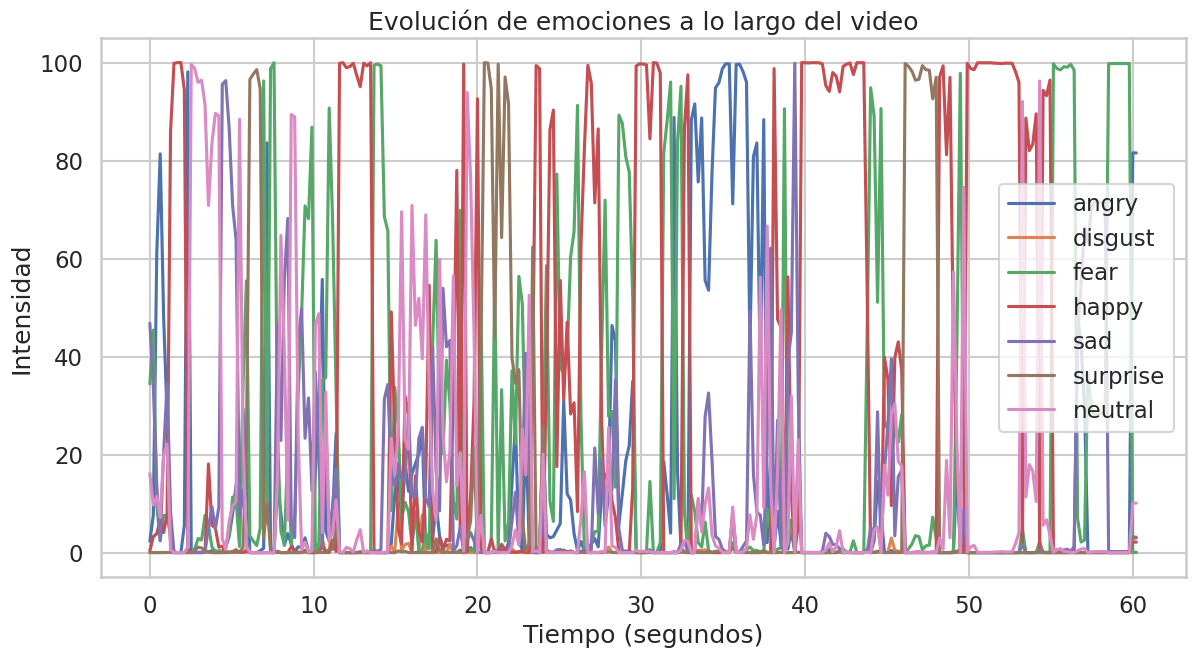

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

for col in emotion_cols.columns:
    plt.plot(df["timestamp_sec"], emotion_cols[col], label=col)

plt.legend()
plt.title("Evolución de emociones a lo largo del video")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Intensidad")
plt.grid(True)
plt.show()

**5.2 Emoción dominante por frame**

Aquí se calcula cuál emoción es predominante en cada instante del video.
Esto permite analizar el comportamiento emocional cuadro por cuadro y detectar patrones como momentos de alegría, sorpresa o neutralidad prolongada.

In [ ]:
# Identificar la emoción dominante para cada frame
df["emotion_dominant_calc"] = emotion_cols.idxmax(axis=1)

# Mostrar primeras filas
df[["timestamp_sec", "emotion_dominant_calc"]].head()

,timestamp_sec,emotion_dominant_calc
0,0.000000,sad
1,0.210553,fear
2,0.421106,angry
3,0.631659,angry
4,0.842212,angry


**5.3 Resumen estadístico de emociones**

En esta sección se genera una tabla con medidas descriptivas (media, mínimos, máximos, desviación estándar), lo cual permite cuantificar el comportamiento emocional general. Además, se determina la emoción predominante en todo el video.

In [ ]:
# Resumen estadístico de las emociones
summary = emotion_cols.describe().T
summary

,count,mean,std,min,25%,50%,75%,max
angry,287.0,12.590513,25.816156,1.763913e-13,3.219159e-03,0.331367,11.268685,99.762993
disgust,287.0,0.210924,1.052339,6.060211e-23,2.563689e-07,0.000603,0.033410,9.556179
fear,287.0,22.528053,32.878874,3.298091e-10,5.772644e-02,3.238689,33.704155,99.960716
happy,287.0,32.804475,42.616877,5.770847e-19,1.141211e-02,2.149196,89.102150,99.995064
sad,287.0,10.905876,19.901620,2.610012e-12,2.807155e-03,0.499176,12.679351,99.864250
surprise,287.0,8.358710,25.581094,1.637584e-20,9.047661e-06,0.002383,0.136520,99.977715
neutral,287.0,12.601449,24.137648,2.644595e-15,1.325433e-02,0.510617,12.929912,99.633965


**5.4 Emoción Predominante Global**

Con base en los promedios que se han calculado, se determina la emoción predominante a nivel global del video. Esta emoción es la que, en promedio, mantuvo la mayor intensidad durante todo el análisis.

In [ ]:
# Emoción predominante total en el video
overall_dominant = df["emotion_dominant_calc"].value_counts().idxmax()
overall_dominant

'happy'

5.5 Promedio de intensidad de emocion

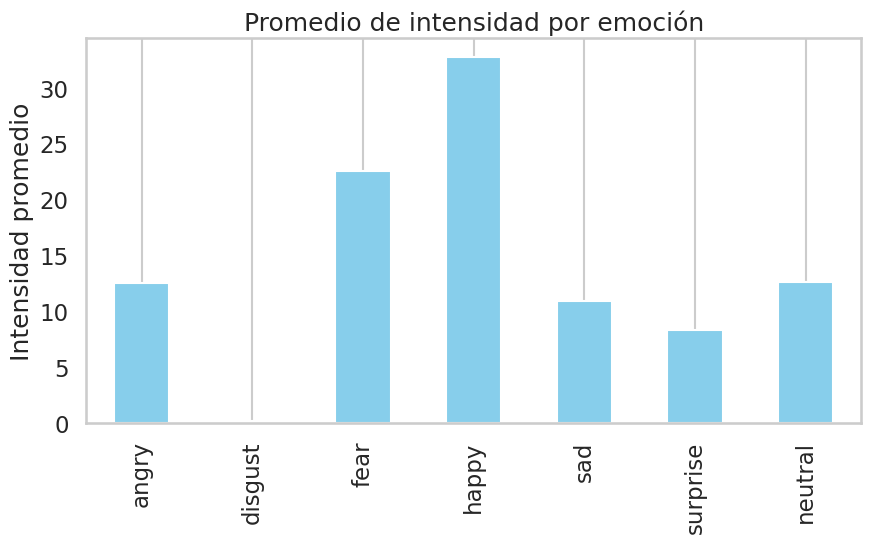

In [ ]:
emotion_means = emotion_cols.mean()

plt.figure(figsize=(10,5))
emotion_means.plot(kind="bar", color="skyblue")
plt.title("Promedio de intensidad por emoción")
plt.ylabel("Intensidad promedio")
plt.grid(axis='y')
plt.show()

**5.6 Evolución Temporal de una Emoción**

Para analizar el comportamiento dinámico de las emociones, se visualiza la evolución temporal de una emoción específica a lo largo del video.

* Este análisis permite observar:

* Picos emocionales.

* Cambios abruptos en la intensidad emocional.

* Momentos clave donde una emoción aumenta o disminuye.

La emoción analizada puede modificarse fácilmente para explorar distintos patrones emocionales.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo bonito para las gráficas
sns.set(style="whitegrid", context="talk")

# Ruta al CSV generado en el notebook
CSV_PATH = "/content/emociones_anuncio_expandido.csv"  # ajustar el nombre si lo cambian

df = pd.read_csv(CSV_PATH)

# Detectar columna de tiempo
time_col = None
for c in ["timestamp_sec", "time_sec", "time", "segundos"]:
    if c in df.columns:
        time_col = c
        break

if time_col is None:
    raise ValueError(
        "No se encontró columna de tiempo. Ajusta el nombre (timestamp_sec / time_sec / time)."
    )

print("Usando columna de tiempo:", time_col)

# Aseguramos que el tiempo sea numérico
df[time_col] = pd.to_numeric(df[time_col], errors="coerce")

# Columnas de emociones
EMOTION_COLS = ["angry", "disgust", "fear",
                "happy", "sad", "surprise", "neutral"]
EMOTION_COLS = [c for c in EMOTION_COLS if c in df.columns]

df[EMOTION_COLS] = df[EMOTION_COLS].apply(pd.to_numeric, errors="coerce")

# Si no existe columna de emoción predominante, la creamos
if "predominante" not in df.columns:
    df["predominante"] = df[EMOTION_COLS].idxmax(axis=1)

df.head()

Usando columna de tiempo: timestamp_sec


,frame,timestamp_sec,emotion,angry,disgust,fear,happy,sad,surprise,neutral,predominante
0,0,0.000000,sad,2.309430,0.005079,34.421097,0.384509,46.786552,1.248209e-07,16.093332,sad
1,5,0.210553,fear,7.607648,0.017498,45.398979,3.231545,34.055435,1.775728e-07,9.688893,fear
2,10,0.421106,angry,60.971928,0.004463,9.743796,3.873978,13.908090,1.711128e-06,11.497740,angry
3,15,0.631659,angry,81.376472,0.002409,2.422272,6.635950,2.403786,3.157900e-06,7.159110,angry
4,20,0.842212,angry,47.878536,0.014793,7.578591,4.081923,20.466311,1.646638e-05,19.979826,angry


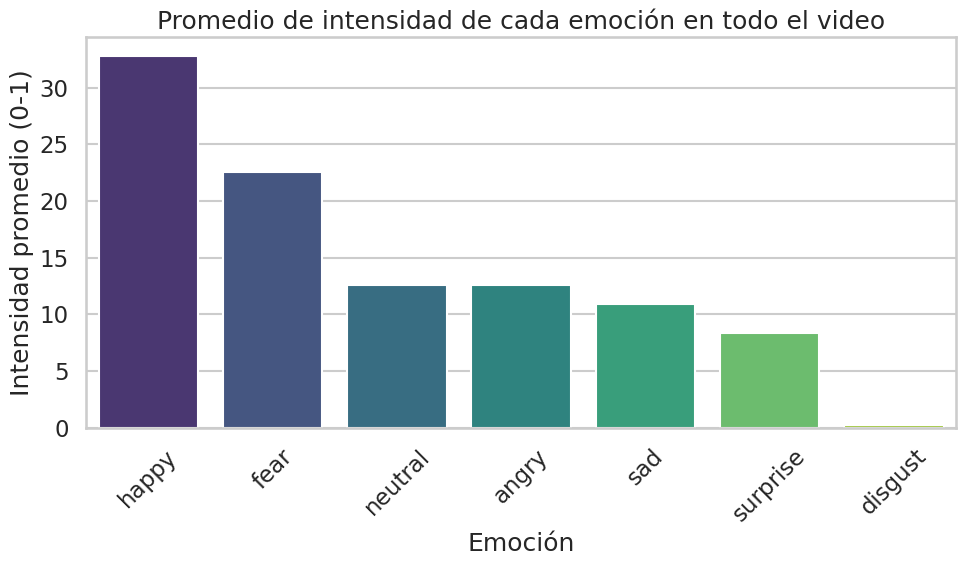

In [ ]:
plt.figure(figsize=(10, 6))
mean_emotions = df[EMOTION_COLS].mean().sort_values(ascending=False)
sns.barplot(x=mean_emotions.index, y=mean_emotions.values, palette="viridis")
plt.title("Promedio de intensidad de cada emoción en todo el video")
plt.ylabel("Intensidad promedio (0-1)")
plt.xlabel("Emoción")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


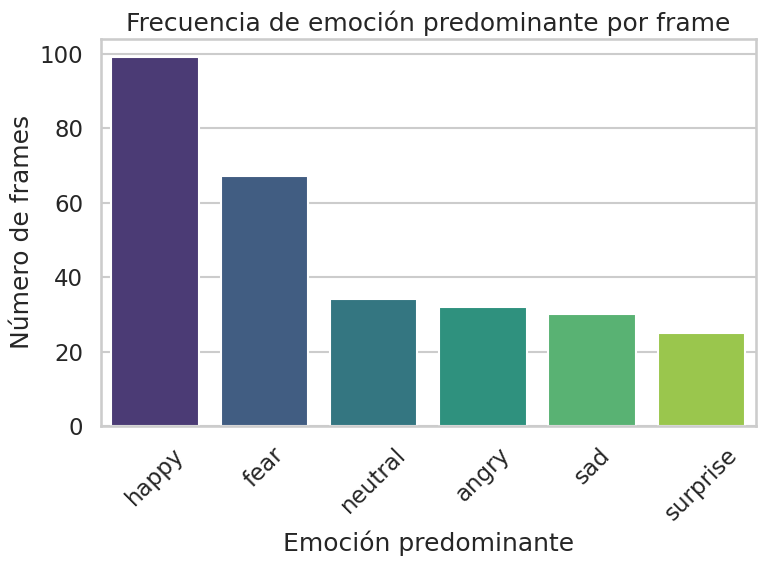

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df["predominante"], order=df["predominante"].value_counts().index, palette="viridis")
plt.title("Frecuencia de emoción predominante por frame")
plt.xlabel("Emoción predominante")
plt.ylabel("Número de frames")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


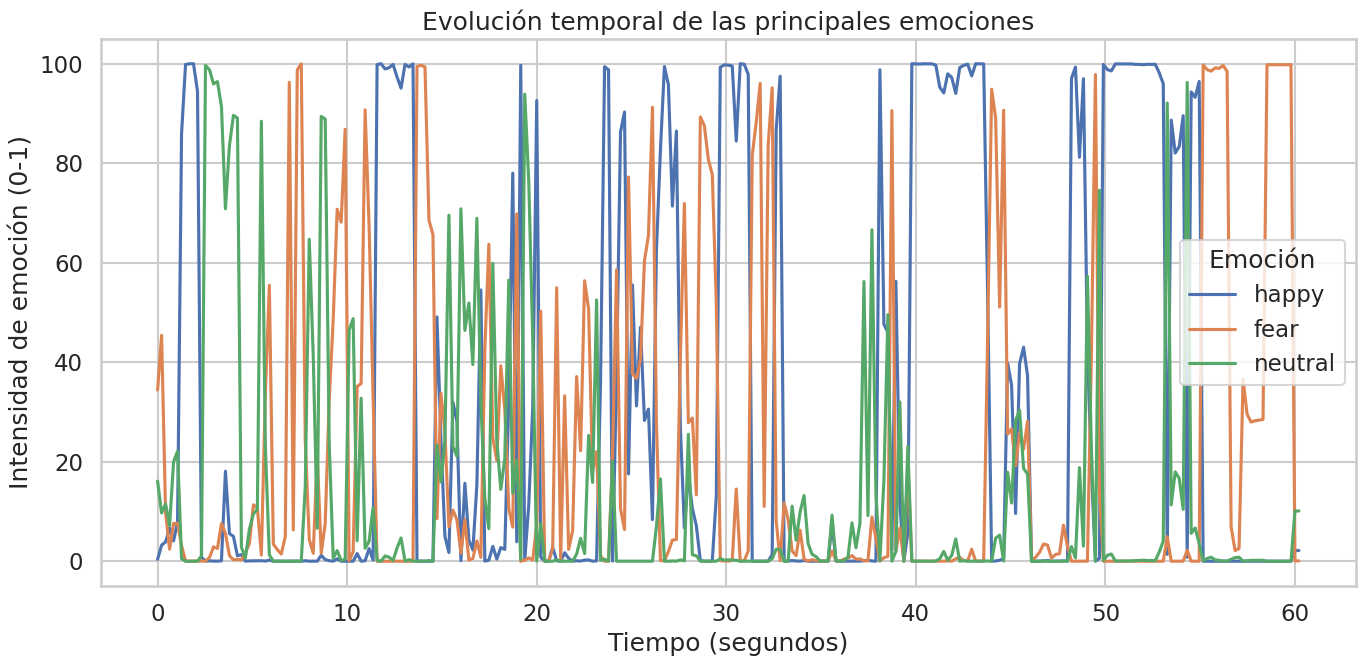

In [ ]:
plt.figure(figsize=(14, 7))

# Escogemos las emociones más importantes (por ejemplo las 3 de mayor promedio)
top_emotions = mean_emotions.index[:3]  # top 3 por promedio

for emo in top_emotions:
    plt.plot(df[time_col], df[emo], label=emo)

plt.title("Evolución temporal de las principales emociones")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Intensidad de emoción (0-1)")
plt.legend(title="Emoción")
plt.tight_layout()
plt.show()


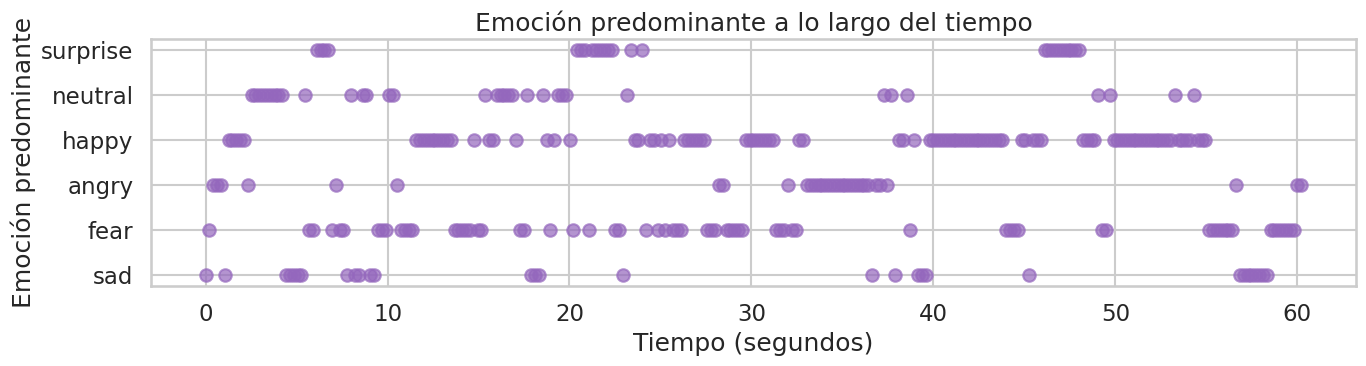

In [ ]:
plt.figure(figsize=(14, 4))

# Para que los puntos no queden encima uno del otro, usamos un jitter pequeño en Y
# pero lo simple también sirve:
plt.scatter(df[time_col], df["predominante"], c="tab:purple", alpha=0.7)

plt.title("Emoción predominante a lo largo del tiempo")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Emoción predominante")
plt.tight_layout()
plt.show()

**5.7 Heatmap de Emociones por Segmentos del Video**

El heatmap representa la intensidad promedio de cada emoción en distintos segmentos temporales del video.

* Este tipo de visualización permite:

* Comparar emociones entre segmentos.

* Identificar patrones repetitivos.

* Observar de forma compacta la evolución emocional completa del video.

Se utiliza una paleta de colores Viridis, adecuada para análisis científicos por su claridad y accesibilidad visual.

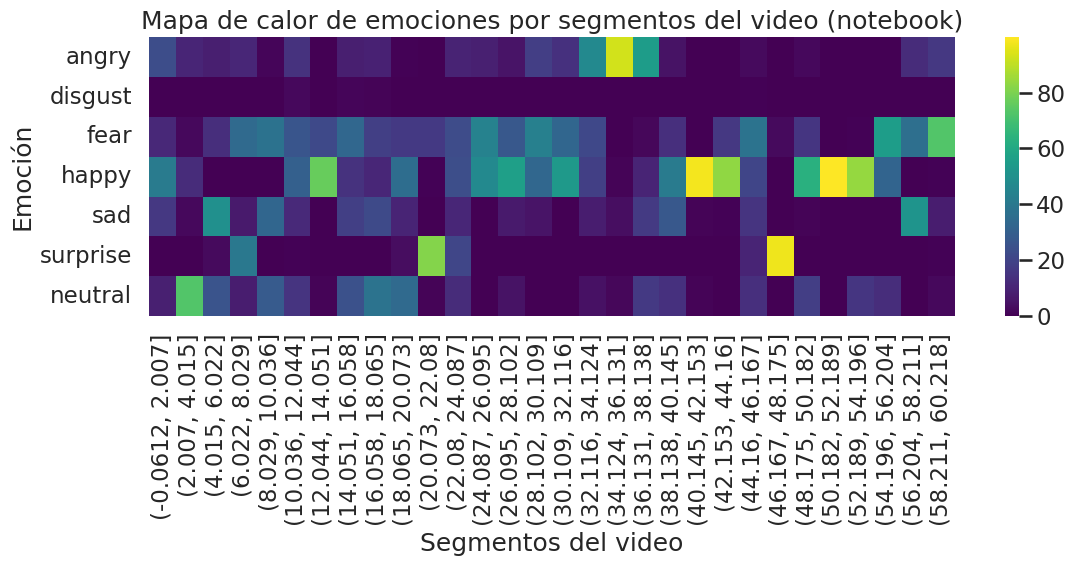

In [ ]:
# Agrupamos en bins para que no sea una locura de columnas
num_bins = min(30, len(df))
temp = df[[time_col] + EMOTION_COLS].copy()
temp["time_bin"] = pd.cut(temp[time_col], bins=num_bins, include_lowest=True)

heat_df = temp.groupby("time_bin")[EMOTION_COLS].mean().T

plt.figure(figsize=(12, 6))
sns.heatmap(heat_df, cmap="viridis")
plt.title("Mapa de calor de emociones por segmentos del video (notebook)")
plt.xlabel("Segmentos del video")
plt.ylabel("Emoción")
plt.tight_layout()
plt.show()

# 6. Interpretación de resultados

A partir del análisis realizado, se puede observar que el video presenta variaciones emocionales claras a lo largo del tiempo, con momentos donde ciertas emociones predominan sobre otras.

La combinación de análisis estadístico y visualizaciones permite interpretar de forma objetiva el impacto emocional del contenido, aportando información valiosa para la toma de decisiones en contextos como publicidad, diseño de contenido o estudios de comportamiento.

**6.1 Código para sacar los datos clave**

In [ ]:
import numpy as np

# 1) Emoción predominante en todo el video
overall_dominant = df["predominante"].value_counts().idxmax()

# 2) Porcentaje de cada emoción dominante (cuántas veces fue la principal)
dominant_counts = df["predominante"].value_counts(normalize=True) * 100

# 3) Top 3 emociones predominantes
top3_dominant = dominant_counts.head(3)

# 4) Promedio global de las intensidades (usa emotion_means que ya calculamos)
emotion_means = emotion_cols.mean().sort_values(ascending=False)

overall_dominant, top3_dominant, emotion_means.head()

('happy',
 predominante
 happy      34.494774
 fear       23.344948
 neutral    11.846690
 Name: proportion, dtype: float64,
 happy      32.804475
 fear       22.528053
 neutral    12.601449
 angry      12.590513
 sad        10.905876
 dtype: float64)

**6.2 Generar un párrafo automático para el informe**

In [ ]:
# Convertimos series a texto legible
top3_text = ", ".join([f"{emo}: {perc:.1f}%" for emo, perc in top3_dominant.items()])

texto_interpretacion = f"""
De acuerdo con el análisis automático del video, la emoción predominante a lo largo de la reproducción fue **{overall_dominant}**.
Al revisar la distribución de emociones dominantes frame por frame, se observa que las tres emociones más frecuentes fueron:
{top3_text}.

En términos de intensidad promedio (considerando todas las emociones detectadas en cada instante del video), las emociones con mayor presencia fueron:
{", ".join([f"{emo} ({val:.2f})" for emo, val in emotion_means.head(3).items()])}.
Esto indica que, en general, el estado emocional del sujeto se inclinó principalmente hacia estas respuestas durante la exposición al anuncio.

La gráfica de evolución temporal de emociones muestra cómo ciertas emociones aumentan en momentos específicos del video, lo que puede relacionarse con escenas clave del contenido publicitario.
Por ejemplo, se pueden identificar picos de emociones como 'happy' o 'surprise' cuando aparece el producto o se muestran mensajes llamativos, mientras que emociones como 'neutral' o 'sad' pueden dominar en segmentos menos dinámicos.

En conjunto, estos resultados permiten concluir que el anuncio genera mayormente una respuesta emocional de tipo **{overall_dominant}**, complementada por las emociones más frecuentes del top 3.
Esta información puede ser utilizada por el equipo de marketing para evaluar si el impacto emocional percibido se alinea con los objetivos de la campaña (por ejemplo, provocar alegría, sorpresa o empatía en la audiencia).
"""

print(texto_interpretacion)


De acuerdo con el análisis automático del video, la emoción predominante a lo largo de la reproducción fue **happy**.
Al revisar la distribución de emociones dominantes frame por frame, se observa que las tres emociones más frecuentes fueron:
happy: 34.5%, fear: 23.3%, neutral: 11.8%.

En términos de intensidad promedio (considerando todas las emociones detectadas en cada instante del video), las emociones con mayor presencia fueron:
happy (32.80), fear (22.53), neutral (12.60).
Esto indica que, en general, el estado emocional del sujeto se inclinó principalmente hacia estas respuestas durante la exposición al anuncio.

La gráfica de evolución temporal de emociones muestra cómo ciertas emociones aumentan en momentos específicos del video, lo que puede relacionarse con escenas clave del contenido publicitario.
Por ejemplo, se pueden identificar picos de emociones como 'happy' o 'surprise' cuando aparece el producto o se muestran mensajes llamativos, mientras que emociones como 'neutral

# 7. Conclusiones

El proyecto muestra que se puede hacer un análisis eficaz de las emociones faciales en videos con herramientas de visión artificial e inteligencia artificial.

Los resultados adquiridos posibilitan:

* Reconocer las emociones predominantes.

* Examinar su conducta a través del tiempo.

* Visualizar patrones emocionales intrincados.

Al incluir más videos, modelos personalizados o análisis comparativos, este método tiene el potencial de expandirse y mejorar la exactitud del reconocimiento emocional.